In [ ]:
from common import *
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import NearestNeighbors

In [2]:
# Load data
position = "forwards" # {forwards, defensemen, goalies}
df = pd.concat([pd.read_csv(f"../nhl-data/data/{f}") for f in os.listdir("../nhl-data/data") if "forwards" in f])

# Filter to NHL regular seasons
df = df[(df["gameTypeId"] == "regular season") & (df["leagueAbbrev"] == "NHL")]
df = df.sort_values(['playerId', 'season'])

# Clean columns
df = df.drop(columns=["Unnamed: 0"])
df["playerName"] = df["firstName"] + " " + df["lastName"]

# Encode avgToi to float
def encode_avgtoi(avgtoi):
    minutes, seconds = avgtoi.split(":")
    return int(minutes) + int(seconds) / 60

df["avgToi_adj"] = df["avgToi"].apply(encode_avgtoi)
df["totalToi"] = df["avgToi_adj"] * df["gamesPlayed"]

# Group trade deadline seasons together
df = df.groupby(["playerId", "season"]).agg(
    team=("teamName", list),
    playerName=("playerName", "max"),
    age=("age", "max"),
    gamesPlayed=("gamesPlayed", "sum"),
    goals=("goals", "sum"),
    assists=("assists", "sum"),
    points=("points", "sum"),
    plusMinus=("plusMinus", "sum"),
    pim=("pim", "sum"),
    powerPlayPoints=("powerPlayPoints", "sum"),
    shots=("shots", "sum"),
    totalToi=("totalToi", "sum"),
).reset_index()

In [3]:
df["avgToi"] = df["totalToi"] / df["gamesPlayed"]
df = df.drop(columns=["totalToi"])
df["yoe"] = df.groupby("playerId").cumcount() + 1
df["playerId"] = df["playerId"].astype(str)
df["season"] = df["season"].astype(str)

# Clean season column
season_lengths = {
    "20192020": 70,    # COVID-shortened (approx; varies a bit by team)
    "20202021": 56,    # COVID-shortened
    "20042005": 0,     # lockout — drop if present
}

df["seasonLength"] = df["season"].map(season_lengths).fillna(82)
df["gpa"] = df["gamesPlayed"] / df["seasonLength"]
df = df[df["seasonLength"] > 0]

# Normalize stats by games played
df["gpg"] = df["goals"] / df["gamesPlayed"]
df["apg"] = df["assists"] / df["gamesPlayed"]
df["spg"] = df["shots"] / df["gamesPlayed"]
df["ppppg"] = df["powerPlayPoints"] / df["gamesPlayed"]

In [4]:
SCHEMA = [
    "playerId",
    "season",
    "playerName",
    "age",
    "yoe",
    "gpa", # games played adjusted
    "gpg", # goals per game
    "apg", # assists per game
    "spg",
    "ppppg",
    "avgToi",
]

In [5]:
INPUT = "Kakko"
INPUT_NAME = max(df[df["playerName"].str.contains(INPUT)]["playerName"]) 
INPUT_YOE = max(df[df["playerName"].str.contains(INPUT)]["yoe"])
INPUT_ID = max(df[df["playerName"].str.contains(INPUT)]["playerId"])
print(f"Looking for players similar to {INPUT_NAME} {INPUT_YOE} years into their career [{INPUT_ID}]")

Looking for players similar to Kaapo Kakko 6 years into their career [8481554]


In [6]:
mdf = df[SCHEMA]
mdf = mdf[mdf["yoe"] <= INPUT_YOE]

In [7]:
gpa_df = pd.pivot(data=mdf, index=["playerId"], columns="yoe", values="gpa").reset_index()
gpa_df = gpa_df.rename(columns={k: f"yoe_{k}_gpa" for k in range(1, gpa_df.columns[-1] + 1)})

gpg_df = pd.pivot(data=mdf, index=["playerId"], columns="yoe", values="gpg").reset_index()
gpg_df = gpg_df.rename(columns={k: f"yoe_{k}_gpg" for k in range(1, gpg_df.columns[-1] + 1)})

apg_df = pd.pivot(data=mdf, index=["playerId"], columns="yoe", values="apg").reset_index()
apg_df = apg_df.rename(columns={k: f"yoe_{k}_apg" for k in range(1, apg_df.columns[-1] + 1)})

spg_df = pd.pivot(data=mdf, index=["playerId"], columns="yoe", values="spg").reset_index()
spg_df = spg_df.rename(columns={k: f"yoe_{k}_spg" for k in range(1, spg_df.columns[-1] + 1)})

ppppg_df = pd.pivot(data=mdf, index=["playerId"], columns="yoe", values="ppppg").reset_index()
ppppg_df = ppppg_df.rename(columns={k: f"yoe_{k}_ppppg" for k in range(1, ppppg_df.columns[-1] + 1)})

avgToi_df = pd.pivot(data=mdf, index=["playerId"], columns="yoe", values="avgToi").reset_index()
avgToi_df = avgToi_df.rename(columns={k: f"yoe_{k}_avgToi" for k in range(1, avgToi_df.columns[-1] + 1)})

In [8]:
# Join stats together
db = gpa_df.merge(gpg_df, on="playerId")
db = db.merge(apg_df, on="playerId")
db = db.merge(spg_df, on="playerId")
db = db.merge(ppppg_df, on="playerId")
db = db.merge(avgToi_df, on="playerId")

In [9]:
db_matrix = db.set_index("playerId")

In [10]:
# Normalize features for KNN
scaler = StandardScaler()
db_matrix = pd.DataFrame(scaler.fit_transform(db_matrix), columns=db_matrix.columns, index=db_matrix.index)

# Impute values
# imp = SimpleImputer(strategy="mean")
imp = SimpleImputer(strategy="constant", fill_value=0)
db_matrix = pd.DataFrame(imp.fit_transform(db_matrix), columns=db_matrix.columns, index=db_matrix.index)

In [11]:
knn = NearestNeighbors(metric="cosine")
knn.fit(db_matrix)

NearestNeighbors(metric='cosine')

In [12]:
INPUT_VECTOR = np.array(db_matrix.loc[INPUT_ID, :]).reshape(1, -1)
INPUT_VECTOR.shape

(1, 36)

In [13]:
distances, indices = knn.kneighbors(INPUT_VECTOR, n_neighbors=10)

/Users/ryanmahtab/.pyenv/versions/3.13.2/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/ryanmahtab/.pyenv/versions/3.13.2/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/ryanmahtab/.pyenv/versions/3.13.2/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/ryanmahtab/.pyenv/versions/3.13.2/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [14]:
nbrs = pd.DataFrame(db_matrix.iloc[indices[0], :].index)

In [15]:
nbrs_stats = df.merge(nbrs, on=["playerId"], how="inner")
print(nbrs_stats["playerName"].unique())

['Matt Nieto' 'Zemgus Girgensons' 'Jimmy Vesey' 'Alexander Kerfoot'
 'Artturi Lehkonen' 'Brett Howden' 'Cody Glass' 'Nils Hoglander'
 'Kaapo Kakko' 'Will Smith']


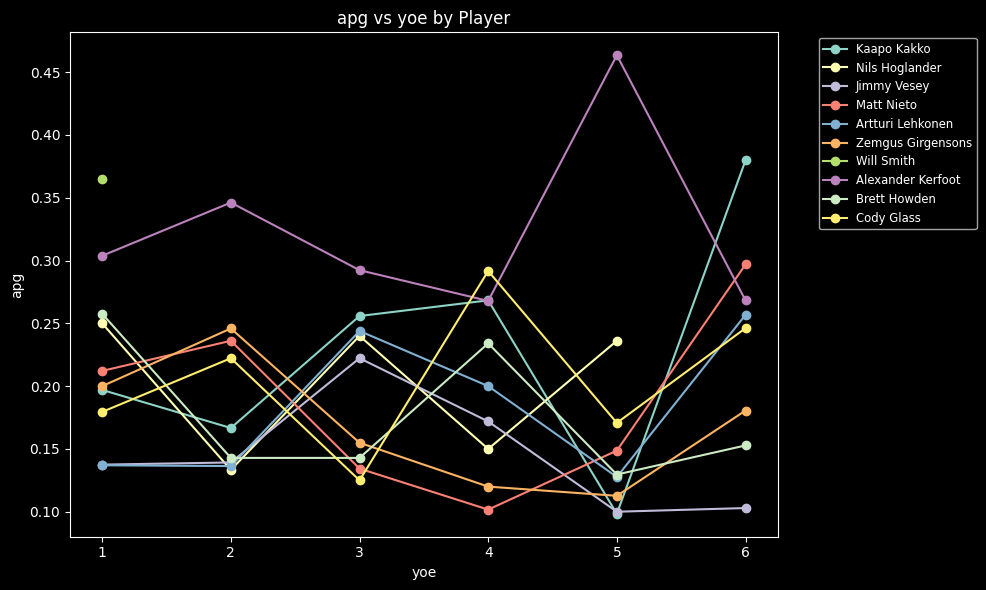

In [16]:
player_ids = nbrs["playerId"]

plt.figure(figsize=(10, 6))

x = "yoe"
y = "apg"

for pid in player_ids:
    subset = mdf[mdf['playerId'] == pid]
    player_name = subset[subset["playerId"] == pid]["playerName"].unique()[0]
    plt.plot(subset[x], subset[y], marker='o', label=player_name)

plt.xlabel(x)
plt.ylabel(y)
plt.title(f"{y} vs {x} by Player")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=1)
plt.tight_layout()
plt.show()

In [17]:
# comps = df[
#     (df["age"].between(30, 30))
#     & (df["experience"].between(12, 12))
#     & (df["goals"].between(20, 22))
# ]
# comps

In [18]:
# grouped = df.groupby(["playerId", "playerName"]).agg(
#     totalGoals=("goals", "sum"),
#     totalAssists=("assists", "sum"),
#     totalPoints=("points", "sum"),
#     totalGamesPlayed=("gamesPlayed", "sum"),
#     totalPlusMinus=("plusMinus", "sum"),
#     currentAge=("age", "max"),
#     currentExp=("yoe", "max"),
# ).reset_index()

In [19]:
# player_ids = grouped[
#     # (grouped["currentAge"].between(33, 33)) &
#     (grouped["totalGamesPlayed"].between(400, 500))
# ]["playerId"]

# plt.figure(figsize=(10, 6))

# x = "age"
# y = "spg"

# for pid in player_ids:
#     subset = mdf[mdf['playerId'] == pid]
#     player_name = subset[subset["playerId"] == pid]["playerName"].unique()[0]
#     plt.plot(subset[x], subset[y], marker='o', label=player_name)

# plt.xlabel(x)
# plt.ylabel(y)
# plt.title(f"{y} vs {x} by Player")
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=1)
# plt.tight_layout()
# plt.show()

In [20]:
# plt.figure(figsize=(10, 6))
# stat = "goals"

# for pid in comps["playerId"]:
#     subset = F[F['playerId'] == pid]
#     player_name = subset[subset["playerId"] == pid]["playerName"].unique()[0]
#     plt.plot(subset['age'], subset[stat], marker='o', label=player_name)

# plt.xlabel('Age')
# plt.ylabel(stat)
# plt.title(f'{stat} vs Age by Player')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=1)
# plt.tight_layout()
# plt.show()

In [21]:
# def scatter(data, x, y):
    
#     plt.scatter(x=data[x], y=data[y])

#     plt.xlim(15, 40)
#     plt.ylim(0, 180)
    
#     plt.xlabel(x)
#     plt.ylabel(y)
#     plt.title(f"{y} vs {x}")
#     plt.show()

# # scatter(df[df["gameTypeId"] == "regular season"], "age", "points")